In [78]:
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages') #Path to libraries in case of no module error
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
import string
import string
import csv
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt 

# First, load wikipedia dump and preprocess text
First we take wikipedia dump and we process that corpus. We remove punctuation and we lowercase all words. For our purpose, we delete all words that length less than three.
Than we save new processed text to trwiki_clean file to use it later.

In [11]:
# load text
filename = 'trwiki'
file = open(filename, 'rt', encoding='utf-8', errors='ignore')
text = file.read()
file.close()
words = text.split()

# remove punctuation, empty spaces and words that has length less than 3 and lower all characters
punct = str.maketrans('', '', string.punctuation)
removed = [word.translate(punct) for word in words]
words = [word for word in removed if len(word) > 3]
words = [word.lower() for word in words]

filename = 'trwiki_clean'
file = open(filename, 'w+', encoding='utf-8')
for word in words:
    file.write(word+' ')
file.close()

# Adding train and test files to big corpus
Than we add train and test data to one big corpus. When we train our vectors for classification, we use this big corpus, while doing word2vec vectorization.

In [12]:
# read train file
reader = csv.DictReader(open('train.csv', 'r', encoding='ISO 8859-9', errors='ignore'))
sentences = []
for sample in reader:
    sentences.append(sample['comment'])
# make comments to one big corpus    
text = ' '.join(sentences)
text = text.replace('.', '. ', text.count('.')).replace(',', ', ', text.count(',')).replace(':', ': ', text.count(':'))
words = text.split()

# remove punctuation, empty spaces and words that has length less than 3 and lower all characters
punct = str.maketrans('', '', string.punctuation)
removed = [word.translate(punct) for word in words]
words = [word for word in removed if len(word) > 3]
words = [word.lower() for word in words]
# append train corpus to total corpus
filename = 'trwiki_clean'
file = open(filename, 'a+', encoding='utf-8', errors='ignore')
for word in words:
    file.write(word+' ')
file.close()

# read test file
reader = csv.DictReader(open('test.csv', 'r', encoding='ISO 8859-9', errors='ignore'))
sentences = []
for sample in reader:
    sentences.append(sample['comment'])
# make comments to one big corpus    
text = ' '.join(sentences)
text = text.replace('.', '. ', text.count('.')).replace(',', ', ', text.count(',')).replace(':', ': ', text.count(':'))
words = text.split()


# remove punctuation, empty spaces and words that has length less than 3 and lower all characters
punct = str.maketrans('', '', string.punctuation)
removed = [word.translate(punct) for word in words]
words = [word for word in removed if len(word) > 3]
words = [word.lower() for word in words]
filename = 'trwiki_clean'
file = open(filename, 'a+', encoding='utf-8', errors='ignore')
for word in words:
    file.write(word+' ')
file.close()

### After that preprocessing we have a corpus that has our wikipedia dump, train set and test set
Now, we can use word2vec to get vectors of words to use it in naive bayes classifier. From there, we go to C code of **Word2Vec** downloaded from https://github.com/tmikolov/word2vec, then we build that code and we give our corpus to that program as parameter. Than we run it as follows:

`./word2vec -min-count 1 -train trwiki_clean -output vectors -save-vocab vocab -size 300`

After that we have 300 dimensional size vector for every word and it is save in `vectors` file. Now we can load vectors into python code and start classifying.

In [13]:
# import word2vec model
model = KeyedVectors.load_word2vec_format('vectors', binary=False)

## Than we run some similarity tests to show vectors are fine.

In [71]:
model.most_similar('oyuncu')

[('aktör', 0.5896717309951782),
 ('oyuncudur', 0.5839625597000122),
 ('oyuncusu', 0.5812033414840698),
 ('oyuncular', 0.5717649459838867),
 ('oyuncunun', 0.5309138894081116),
 ('aktris', 0.5197291970252991),
 ('akalmar', 0.5161633491516113),
 ('oyunculardan', 0.49662989377975464),
 ('yovoviç', 0.4713529944419861),
 ('oyunucu', 0.46616968512535095)]

In [16]:
model.most_similar(positive=['kadın', 'kral'], negative=['erkek'])

[('kralın', 0.5178984999656677),
 ('kraliçe', 0.5150195360183716),
 ('kralı', 0.47850877046585083),
 ('krala', 0.44080325961112976),
 ('kraliçenin', 0.4322437644004822),
 ('prens', 0.43116503953933716),
 ('kraliçesi', 0.4261987805366516),
 ('kraliçeyi', 0.40540170669555664),
 ('prensin', 0.3856278657913208),
 ('satrap', 0.3827993869781494)]

## Creating feature vectors for comments
Our dataset consist of comments with label data. Every comment consist of words. To derive vector feature for per comment, we can consider word vectors. There are many methods to derive a sentence's vector. These are maximum of elementwise every word vector that create sentence. Other is elementwise minimum and the last one average of word vectors. In this project, I used elementwise maximum.

First, we read train file and strip comments from train file. Than we process every comment as we do preprocessing of text chapter. After that, we look every word vector presentation of word from word2vec model, then for every comment we end up with one feature vector that elementwise maximum of word vector that create comment. These vectors have same dimension with word vectors and these all appended to a one big feature matrix to give classifier as input.

We do same operation on test set. Then we have train and test vectors, also labels have already in correct form that we can process by classifier.

In [18]:
# open train file
file = open('train.csv', 'r', encoding='ISO 8859-9', errors='ignore')
train_data = pd.read_csv(file)

# get train data, preprocess comments and labels
train_corpus = []
train_sentence_label = []
for index in range(len(train_data['comment'])):
    comment = train_data['comment'][index]
    comment = comment.replace('.', '. ', comment.count('.')).replace(',', ', ', comment.count(',')).replace(':', ': ', comment.count(':'))
    words = comment.split()
    punct = str.maketrans('', '', string.punctuation)
    removed = [word.translate(punct) for word in words]
    words = [word for word in removed if len(word) > 3]
    words = [word.lower() for word in words]
    if(words != []):
        train_corpus.append(words)
        train_sentence_label.append(train_data['Label'][index])

# convert every sentence to one feature vector with same dimension of word
# add every sentence vector to one big feature matrix. Every row is a senctence vector.
train_sentences_vec = []
for sentence in train_corpus:
    temp = model[sentence[0]]
    for word in sentence:
        temp = np.maximum(temp, model[word])
    train_sentences_vec.append(temp)     

# open test file
file = open('test.csv', 'r', encoding='ISO 8859-9', errors='ignore')
test_data = pd.read_csv(file)

# get test data, preprocess comments and labels
test_corpus = []
test_sentence_label = []
for index in range(len(test_data['comment'])):
    comment = test_data['comment'][index]
    comment = comment.replace('.', '. ', comment.count('.')).replace(',', ', ', comment.count(',')).replace(':', ': ', comment.count(':'))
    words = comment.split()
    punct = str.maketrans('', '', string.punctuation)
    removed = [word.translate(punct) for word in words]
    words = [word for word in removed if len(word) > 3]
    words = [word.lower() for word in words]
    if(words != []):
        test_corpus.append(words)
        test_sentence_label.append(test_data['Label'][index])

# convert every sentence to one feature vector with same dimension of word
# add every sentence vector to one big feture matrix. Every row is a senctence vector.
test_sentences_vec = []
for sentence in test_corpus:
    temp = model[sentence[0]]
    for word in sentence:
        temp = np.maximum(temp, model[word])
    test_sentences_vec.append(temp)

# convert every feature matrix to proper 2d numpy array
train_set = np.empty((0, 300), float)
for vector in train_sentences_vec:
    train_set = np.append(train_set, np.reshape(vector,(-1,300)), axis=0)
test_set = np.empty((0, 300), float)
for vector in test_sentences_vec:
    test_set = np.append(test_set, np.reshape(vector,(-1,300)), axis=0)
#convert label arrays to numpy array
train_label = np.array(train_sentence_label)
test_label = np.array(test_sentence_label)

## Now, we can pass to classification stage.


In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from sklearn.preprocessing import KBinsDiscretizer

## Naive Bayes
In this project we used naive bayes classifiers. Naive bayes classifier assumes that features are independent from other features. Base of this classifier is bayes theorem. The "naive" comes from this assumption of independence.

We have features for our documents these are vectors and they constitute our train set to NB classifier. We have finite set of label that associated with every vector that we use in training step.

Naive bayes classifiers have many implementetion according to input data. Here, we have word2vec vectors and these are continuous data. They have negative and poisitive, floating point numbers inside. From there we have different approaches:

1.We may assume values creates a normal(Gaussian) probability distribution and we can use Gaussian NB classifier. Gaussian NB classifier can deal with continuous and negative values of features.
2.We can use discretize method to have discrete features in our comment vectors then we can use Multinomial NB classifier. Multinomial NB can deal with discrete values but not like Bernoulli NB, which only deal with binary values, it can deal with varying number of inputs.

We used sklearn library to fit and train these NB classifiers. 
Calculation methods are explained in report file.

### Gaussian NB

In [91]:
# create a gaussian naive bayes classifier and train.
gnb = GaussianNB()
labeled_gnb = gnb.fit(train_set, train_label).predict(test_set)

In [92]:
print("Mislabeled comment number is {} in total {} comment and accuracy of Gaussian NB classifier {:.2f}".format(
    (test_label != labeled_gnb).sum(), test_set.shape[0], sklearn.metrics.accuracy_score(test_label, labeled_gnb)))

Mislabeled comment number is 908 in total 2665 comment and accuracy of Gaussian NB classifier 0.66


In [93]:
# preprocess given sentence sample
comment = 'kelimenin tam anlamıyla başyapıt bir film.'
comment = comment.replace('.', '. ', comment.count('.')).replace(',', ', ', comment.count(',')).replace(':', ': ', comment.count(':'))
words = comment.split()
punct = str.maketrans('', '', string.punctuation)
removed = [word.translate(punct) for word in words]
words = [word for word in removed if len(word) > 3]
words = [word.lower() for word in words]
vector = model[words[0]]
for word in words:
    vector = np.maximum(vector, model[word])
    
# convert sentence to proper 2d numpy array and predict
np_vector = np.empty((0, 300), float)
np_vector = np.append(np_vector, np.reshape(vector,(-1,300)), axis=0)
print("Probability of given sentence is negative comment {}".format(gnb.predict_proba(np_vector)[0,0]))
print("Probability of given sentence is positive comment {}".format(gnb.predict_proba(np_vector)[0,1]))
if(gnb.predict_proba(np_vector)[0,0] > gnb.predict_proba(np_vector)[0,1]):
    print("Given sentence is a negative comment")
else:
    print("Given sentence is a positive comment")

Probability of given sentence is negative comment 0.00041669791017453107
Probability of given sentence is positive comment 0.9995833020898278
Given sentence is a positive comment


### Multinomial NB

In [94]:
# create a multinomial naive bayes classifier and train.
discretizer = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='uniform')
train_set_discrete = discretizer.fit_transform(train_set)
test_set_discrete = discretizer.fit_transform(test_set)
mnb = MultinomialNB()
labeled_mnb = mnb.fit(train_set_discrete, train_label).predict(test_set_discrete)

In [95]:
print("Mislabeled comment number is {} in total {} comment and accuracy of Multinomial NB classifier {:.2f}".format(
    (test_label != labeled_mnb).sum(), test_set.shape[0], sklearn.metrics.accuracy_score(test_label, labeled_mnb)))

Mislabeled comment number is 845 in total 2665 comment and accuracy of Multinomial NB classifier 0.68


In [96]:
# preprocess given sentence sample
comment = 'kelimenin tam anlamıyla başyapıt bir film.'
comment = comment.replace('.', '. ', comment.count('.')).replace(',', ', ', comment.count(',')).replace(':', ': ', comment.count(':'))
words = comment.split()
punct = str.maketrans('', '', string.punctuation)
removed = [word.translate(punct) for word in words]
words = [word for word in removed if len(word) > 3]
words = [word.lower() for word in words]
vector = model[words[0]]
for word in words:
    vector = np.maximum(vector, model[word])

# scale given sample vector and predict.
vector = vector.reshape(-1,1)
vector = discretizer.fit_transform(vector)
vector = vector.reshape(1,-1)
print("Probability of given sentence is negative comment {}".format(mnb.predict_proba(vector)[0,0]))
print("Probability of given sentence is positive comment {}".format(mnb.predict_proba(vector)[0,1]))
if(mnb.predict_proba(vector)[0,0] > mnb.predict_proba(vector)[0,1]):
    print("Given sentence is a negative comment")
else:
    print("Given sentence is a positive comment")

Probability of given sentence is negative comment 0.2165894736086417
Probability of given sentence is positive comment 0.7834105263919618
Given sentence is a positive comment


## Confussion matrices for Gaussian NB and Multinomial NB

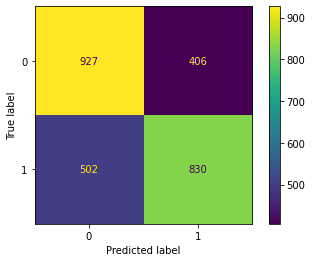

In [101]:
sklearn.metrics.plot_confusion_matrix(gnb, test_set, test_label) 
plt.savefig('gauss.png')
plt.show()

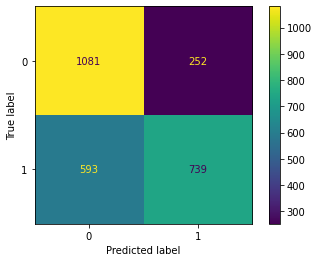

In [102]:
sklearn.metrics.plot_confusion_matrix(mnb, test_set_discrete, test_label) 
plt.savefig('multi.png')
plt.show()